# Integrated DNA damage-TMZ model

This notebook contain the interactive code of an model of DNA damage induced by Temozolomide(TMZ) and the dynamics of the repair mecahnisms. 





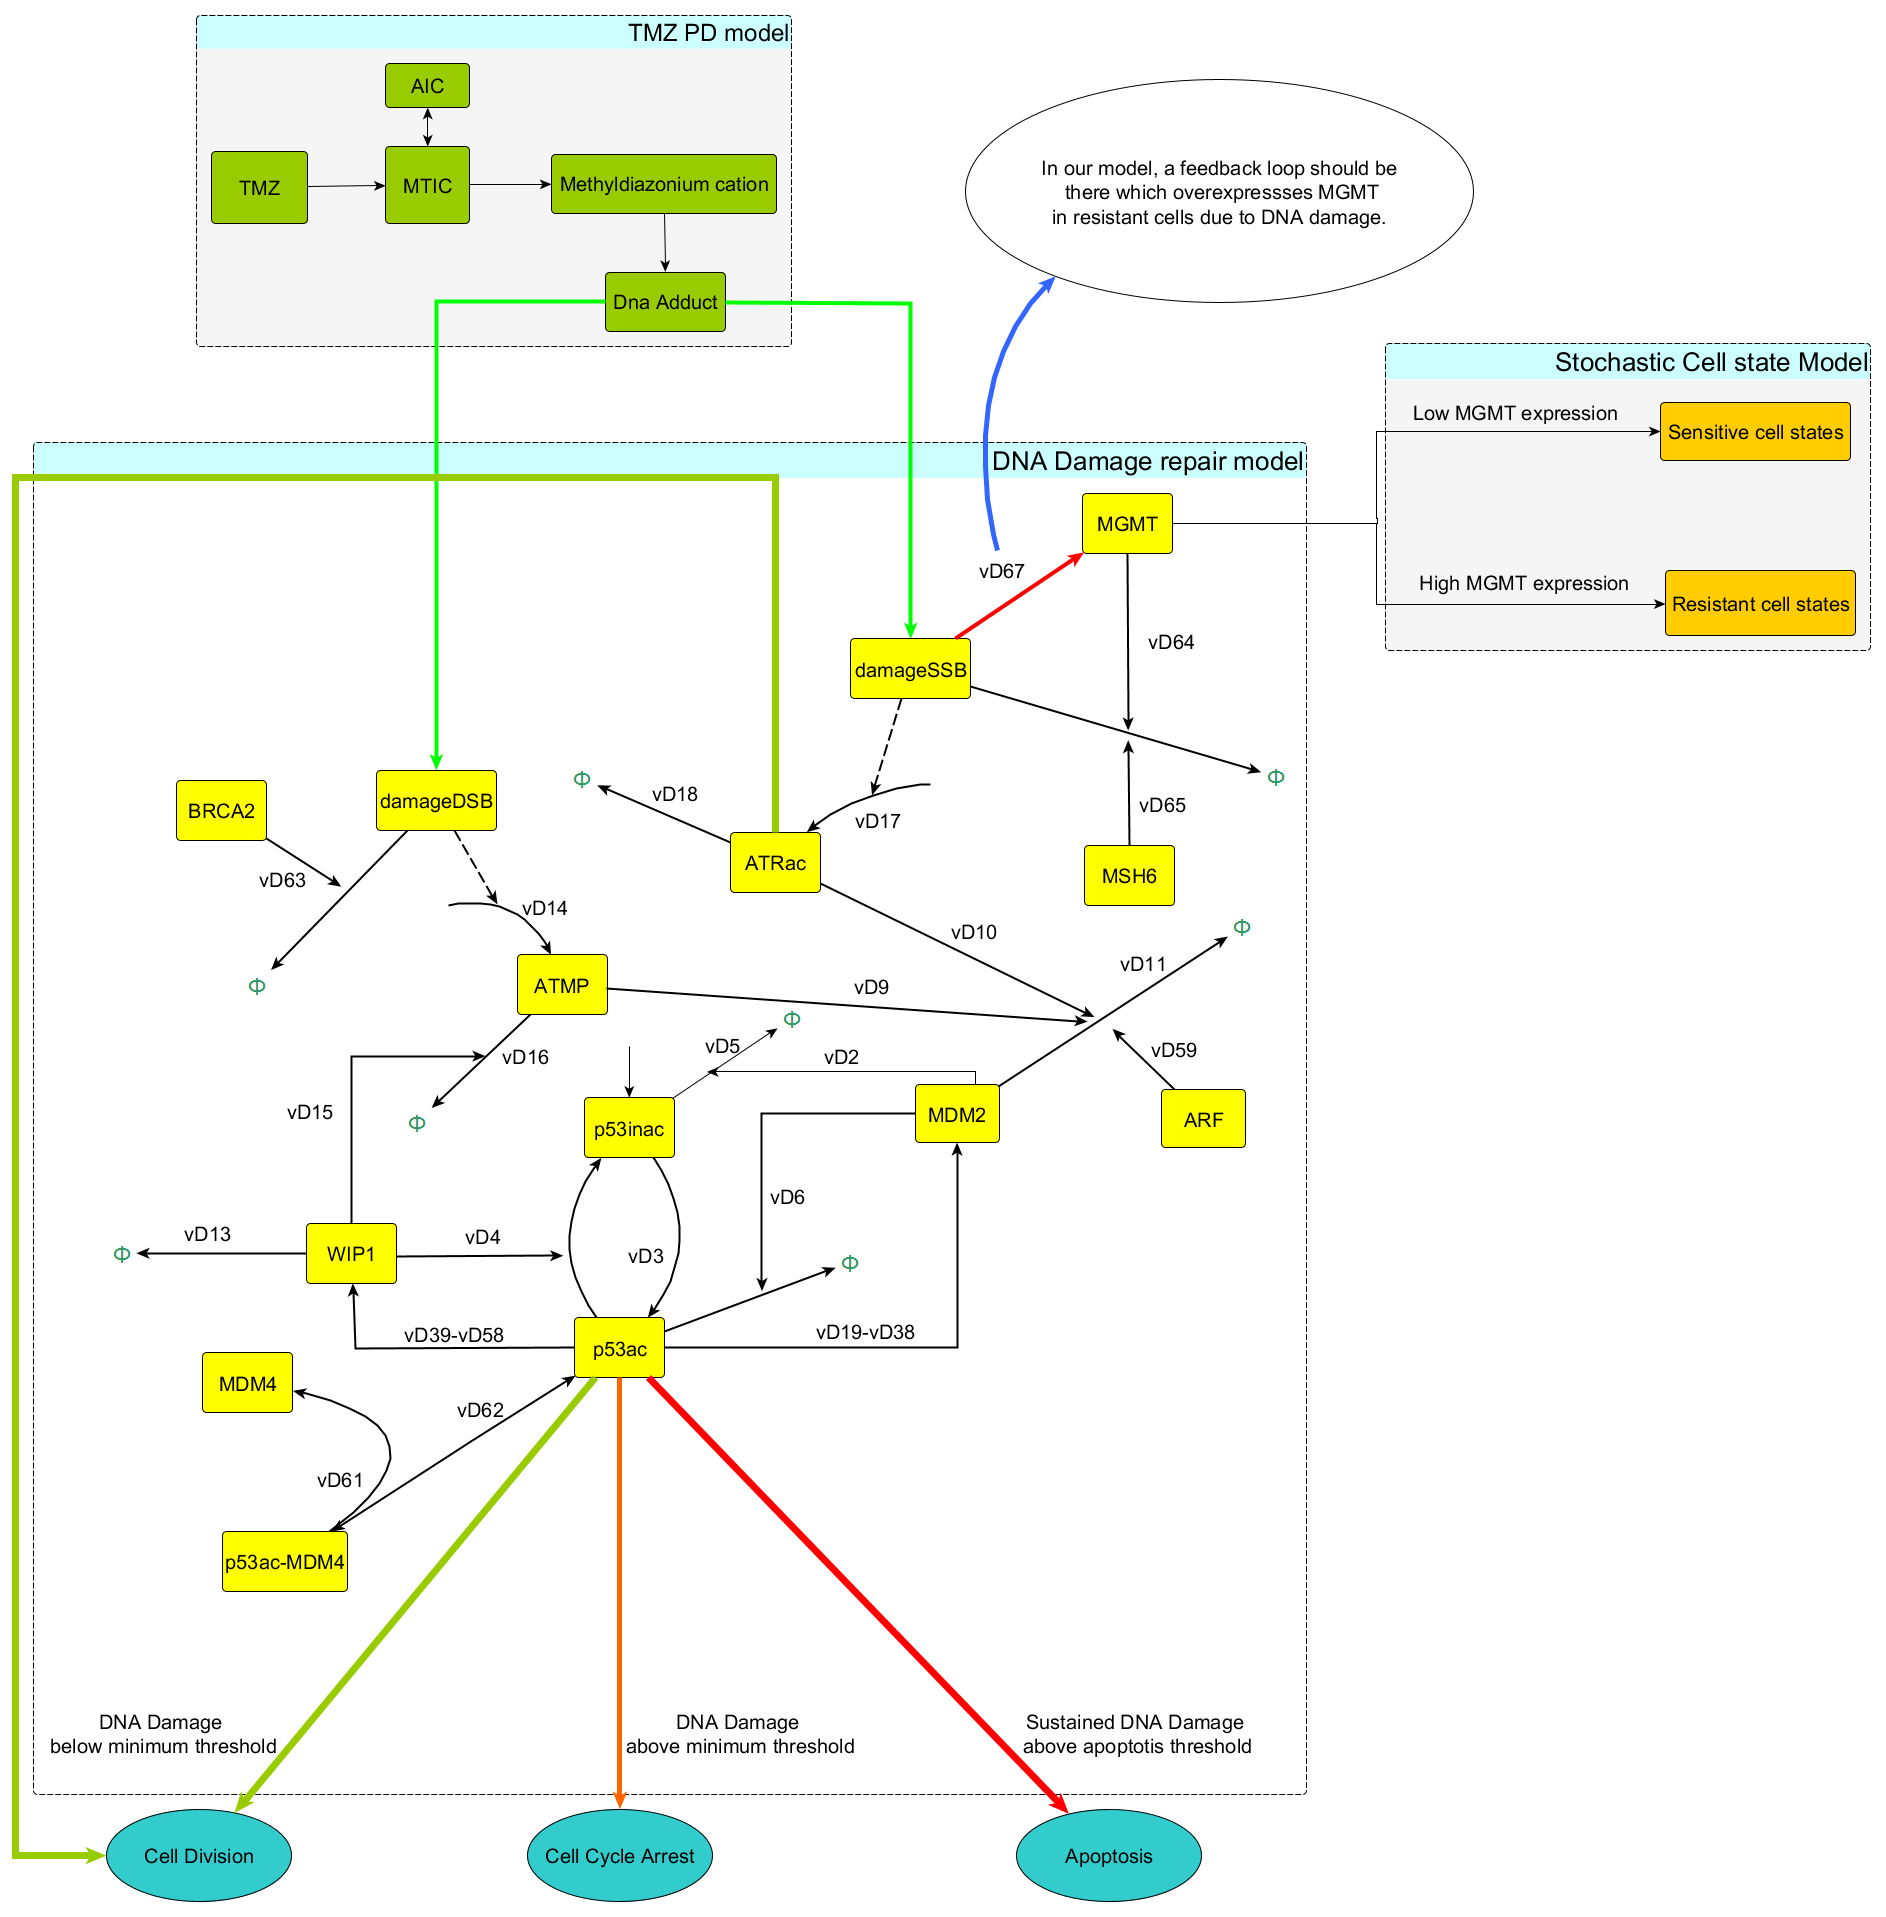

In [47]:
from IPython.display import Image
Image(filename='Model_figure.png')


## TMZ PK ODEs

In the  cell below, the code contain the function which return the ODEs governing the PK of TMZ.


In [35]:
import numpy as np

def ORAL_ODE(u, t):
 
    fif = 0.3;# % unitless, volume fraction of  interstitial fluid (IF) in brain tumor
    fbl = 0.05;# % unitless, volume fraction of blood in brain tumor
    fic = 0.65; #% unitless, volume fraction of intracellular (IC) compartment in brain tumor
    Vbl = 0.0025; #% L, blood volume of brain tumor, Vtu*fbl
    Vtu = 0.05; #% L, total volume of the brain tumor
    Vif = 0.015; #%L, volume of the tumor IF compartment
    Vic = 0.0325;# % L, volume of the IC compartment
    Nic0 = 4.063e9;# % number of toal cells in IC compartment at time=0
    
    fGP = 0.10;# % unitless, initial fraction of IC cells occupied by GP cells
    fQ = 0.80; #% unitless, initial fraction of IC cells occupied by Q cells
    fGS0 = 0.05; #% unitless, initial fraction of GS0 cells
    fGS1 = 0.025; #% unitless, initial fraction of GS1 cells
    fGS2 = 0.025; #% unitless, initial fraction of GS2 cells 
    
    conNV = 1.25e11; #% conversion of cell number to L
    
    #% TMZ pH-dependent metabolic degradation
    pHbl = 7.4; #% blood pH
    pHif = 7.3; #% IF pH
    pHic = 7.2; #% IC pH
    kT0 = 1.1e-7;# % hr-1, baseline TMZ degradation constant
    kM0 = 292; #% hr-1, baseline MTIC degradation constant
    lambdaT = 2.08; #% TMZ empirical
    lambdaM = 0.31; #% MTIC empirical
    
    
    #% TMZ Transport Parameters
    qT = 0.019; #% L/hr, TMZ blood to IF clearance
    qT2 = 0.069; #% L/hr, TMZ IF to blood clearance
    pT = 17.5; #% L/hr, TMZ IF to IC clearance
    pT2 = 36.3; #% L/hr, TMZ IC to IF clearance
    
    #% TMZ forcing function/systemic
    ka = 3.0; #% hr-1, TMZ absorption rate constant
    kel = 0.35; #% hr-1, TMZ elimination rate constant
    Vd = 30.; #% L, apparent volume of distribution
    
    #%TMZ PD
    kadd = 1.81; #% hr-1, DNA adduct formation rate constant
    kdeg = 6000.; #% hr-1, methylating cation degradation constant
    kDNAoff = 0.0041; #% hr-1, DNA adduct degradation rate constant
    
    #%Cell-Type Parameters
    DNAaddMAX = 7.4e-3; #% uM, Maximum DNA adduct concentration without kDNAoff
    sigDNAaddGP = 1.0; #% unitless, empirial amplification exponent for DNA adduct effect
    sigDNAaddGS0 = 1.0; #% unitless, empirial amplification exponent for DNA adduct effect
    proGP =1.8e-3; #% 1/hr, proliferation rate constant of GP cells
    sigGP = 0.18;  #% unitless, exponent in logistic equation for GP 
    
    proGS0 =1.8e-3; #% 1/hr, proliferation rate constant of glioma stem cell state 0 (GS0) cells
    sigGS0 = 0.18;  #% unitless, exponent in logistic equation for GS0
    
    kQGP = 2.0e-5; #% hr-1, transfer rate constant of Q cells to proliferating glioma (GP) cells 
    kGS2GP = 2.0e-5;  #% hr-1, transfer rate constant of glioma stem cell state 2 (GS2) to GP
    kGPQ = 4.0e-4; #% hr-1, transfer rate constant of GP cells to Q cells
    kGPGS0 = 2.0e-5; #% hr-1, transfer rate constant of GP cells to GS0 cells
    kGS0Q = 4.0e-4;  #% hr-1, transfer rate constnat of glioma stem cell state 0 (GS0) to Q cells
    kQGS0 = 2.0e-5;  #% hr-1, transfer rate constnat of  Q cells to GS0 cells
    GStau = 2.0e-5;  #% hr-1, transfer rate constant of GS between states
    
#   rename input u_0
    aTgi = u[0];
    aTbl = u[1];
    Tif = u[2];
    Tic = u[3];
    Mic = u[4];
    meCic = u[5];
    DNAadd = u[6];

#   pH-dependent rate constants
    kTif = kT0*np.exp(lambdaT*pHif);
    kTic = kT0*np.exp(lambdaT*pHic);
    kMic = kM0*np.exp(lambdaM*pHic);
    
#   ODEs
    ddt_aTgi = -ka*aTgi;
    ddt_aTbl = ka*aTgi - kel*aTbl;
    Tbl = aTbl/Vd;
    
    ddt_Tif = (qT*Tbl - qT2*Tif - pT*Tif + pT2*Tic)/Vif - kTif*Tif;
    ddt_Tic = ( pT*Tif - pT2*Tic)/Vic - kTic*Tic;
    
    ddt_Mic = kTic*Tic - kMic*Mic;
    ddt_meCic = kMic*Mic - kadd*meCic - kdeg*meCic;
    
    ddt_DNAadd = kadd*meCic - kDNAoff*DNAadd;
          
    w = np.zeros(7);
    w[0] = ddt_aTgi;
    w[1] = ddt_aTbl;
    w[2] = ddt_Tif;
    w[3] = ddt_Tic;
    w[4] = ddt_Mic;
    w[5] = ddt_meCic;
    w[6] = ddt_DNAadd;
    
    dudt = np.transpose(w);
    return dudt   
    

## TMZ multidose PK

In the cell below, the code contains the multidose regiment of the TMZ. It returns the value of DNA adduct as a function of time. The output of this function is used in the integrated model to induce the DNA damage. 


In [36]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 25 19:21:59 2021

@author: anshulsa
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from oral_ode_file import ORAL_ODE



def Oral_TMZ(th,TMZ_Dose,TimeOfDoses):

    Vd = 30.; #% L, apparent volume of distribution

    #%TMZ Cell death parameters
    kDeadTMZ = 2.0e-4; #% hr-1, death rate constant due to TMZ
      
    #%EQUATION:
    aTgi_0 = 0;  #%aTgi = TMZ dose into gut and is equal to 1300
    
    #% ICs for ODE
    aTbl_0 = 0;
    Tif_0 = 0;
    Tic_0 = 0;
    Mic_0 = 0;
    meCic_0 = 0;
    DNAadd_0 = 0;
        
    u0 = [aTgi_0, aTbl_0, Tif_0, Tic_0, Mic_0, meCic_0, DNAadd_0];
    
    hr = 3600;
    div = 1800;
    
    c_meth_list = [];  
    DNA_adduct_list =  [];
    dose_reg = np.size(TMZ_Dose);
    
    if TimeOfDoses[0] == 0:
       
        C0 = TMZ_Dose; #%in microM
        u0[0] = C0;
    
        #%Time in hours
        delta=(TimeOfDoses[1]*hr)/div;
        t= np.linspace(0, TimeOfDoses[1],delta);
                
        u_average = odeint(ORAL_ODE, u0, t);
        
        for i in range(0, len(t)):
            c_meth_list.append(u_average[i, 5])
            DNA_adduct_list.append(u_average[i, 6])
        
        for i in range(0, len(TimeOfDoses)-1):
            
            time_dif = TimeOfDoses[i+1]-TimeOfDoses[i];
            delta=(time_dif*hr)/div;
            t = np.linspace(0,time_dif,delta);
            
            u0 = u_average[-1, :];
            
            if dose_reg > 1:
                C0 = TMZ_Dose;
                u0[0] = u0+C0;
            else:
                C0 = TMZ_Dose;
                u0[0] = u0[0]+C0;
        
            u_average = odeint(ORAL_ODE, u0, t);
            
            for i in range(0, len(t)):
                c_meth_list.append(u_average[i, 5])
                DNA_adduct_list.append(u_average[i, 6])
           
        
        time_dif = th-TimeOfDoses[-1];
        delta = int((time_dif*hr)/div);
        t = np.linspace(0,time_dif,delta);
        
        
        u0 = u_average[-1, :];
        C0 = TMZ_Dose;
        u0[0] = u0[0]+C0;
                
        u_average = odeint(ORAL_ODE, u0, t);
        for i in range(0, len(t)):
            c_meth_list.append(u_average[i, 5])
            DNA_adduct_list.append(u_average[i, 6])
  
    
    else:
       
        C0 = 0; # %in microM
        u0[0] = C0;
        print(u0)
        delta = int((TimeOfDoses[0]*hr)/div);
        t = np.linspace(0,TimeOfDoses[0],delta);
   #     print(len(t))
        
        u_average = odeint(ORAL_ODE, u0, t);
        
        for i in range(0, len(t)):
            c_meth_list.append(u_average[i, 5])
            DNA_adduct_list.append(u_average[i, 6])
   #     print(len(c_meth_list))
            #print(i)
        
        for i in range(0, len(TimeOfDoses)-1):
            
            time_dif = TimeOfDoses[i+1]-TimeOfDoses[i];
            delta = int((time_dif*hr)/div);
            t = np.linspace(0,time_dif,delta);
            #print(i)
    #       print(len(t))
            u0 = u_average[-1, :];
            #print(u0)
            if dose_reg > 1:
                C0 = TMZ_Dose;
                u0[0] = C0 + u0[0];
            else:
                C0 = TMZ_Dose;
                u0[0] = C0 + u0[0];
            #print(u0)       
            u_average = odeint(ORAL_ODE, u0, t);
            #print(u_average[-1]);
            for i in range(0, len(t)):
                c_meth_list.append(u_average[i, 5])
                DNA_adduct_list.append(u_average[i, 6])
  #          print(len(c_meth_list))
        
        
        time_dif = th - TimeOfDoses[-1];
        delta = int((time_dif*hr)/div);
        t = np.linspace(0, time_dif, delta);
 #       print(len(t))
        
        u0 = u_average[-1, :];
        C0 = TMZ_Dose;
        u0[0] = C0 + u0[0];
        
        u_average = odeint(ORAL_ODE, u0, t);   

        for i in range(0, len(t)):
            c_meth_list.append(u_average[i, 5])
            DNA_adduct_list.append(u_average[i, 6])
        
   #     print(len(c_meth_list))
    
    
    c_meth_list_cali = []
    DNA_adduct_list_cali = []
    
    c_meth_list_cali = [i*(7*(10**-12)/(2*(10**-12)))*1000 for i in c_meth_list] #%Convert to nM
    DNA_adduct_list_cali = [i*(7*(10**-12)/(2*(10**-12)))*1000 for i in DNA_adduct_list] #%Convert to nM

#    amt_bl = plasma/Vd;
#     
    tplot = np.linspace(0, th, int(th*hr/div))
#    print(len(tplot))
    plt.plot(tplot, c_meth_list_cali);
    plt.ylabel('Methylating Cation (nM)')
    plt.xlabel('Time Hours')
    plt.show()
    
    plt.plot(tplot, DNA_adduct_list_cali);
    plt.ylabel('DNA_adduct (nM)')
    plt.xlabel('Time Hours')
    plt.show()
    
    return DNA_adduct_list_cali


## DNA Damage model ODEs

In the cell below, the code contains function (derivative) which returns the ODEs representing the DNA damage submodule extracted from the pan-cancer model(PCM) developed by Birtwistle lab. The parameter tmz_stim is the input parameter in the function through which the TMZ is causing DNA damage in the model. The output of the function returns the set of ODEs which governs the dynamics of the DNA damage (damage_DSB and damage_SSB) and the repair enzymes like p53, MGMT, MSH6, ..etc. 

In [37]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 25 19:34:49 2021

@author: anshulsa
"""

import numpy as np
from numpy import genfromtxt

stoichometric_mat = genfromtxt('SM_DNA_damage.csv', delimiter=',')

def derivative(s, t, tmz_stim, i, kD_brca_input, kD_msh6_input, kD_mgmt_input):
    
    #dS = np.zeros(38)
    vD = np.zeros((66, 1)) 
    kD = np.zeros(60)
    dS = np.zeros(38)
    
    #kD **
    kD[1]=0.9*(1000/3600);
    kD[2]=5/(1000*3600);
    kD[3]=2/3600;
    kD[4]=10/3600;
    kD[5]=4; 
    kD[6]=1*1000;
    kD[7]=1.4/(1000*3600) ;
    kD[8]=0.14/(1000*3600);
    kD[9]=0.9/3600;
    kD[10]=0.2*(1000/3600);
    kD[11]=1/3600;
    kD[12]=0.5/(1000*3600);
    kD[13]=0.25/3600;
    kD[14]=0.7/3600;
    kD[15]=0.1/(1000*3600); 
    kD[16]=50/3600; 
    kD[17]=4; 
    kD[18]=0.2*1000;
    kD[19]=7.5/3600;
    kD[20]=10*(1000/3600);
    kD[21]=0.6075*(1000/3600);#4.5*(1000/3600);
    kD[22]=0.033948*3600;
    kD[23]=0.058614*3600;
    kD[24]=0.0035778*3600;
    kD[25]=0.33705*3600;
    kD[26]=0.013496*3600;
    kD[27]=0.030939*3600;
    kD[28]=0.0042462*3600;
    kD[29]=0.081109*3600;
    kD[30]=0.10093*3600;
    kD[31]=0.13295*3600;
    kD[32]=0.080377*3600;
    kD[33]=0.12247*3600;
    kD[34]=0.16522*3600;
    kD[35]=0.099235*3600;
    kD[36]=0.13629*3600;
    kD[37]=0.28505*3600;
    kD[38]=0.10575*3600;
    kD[39]=0.066299*3600;
    kD[40]=0.11092*3600;
    kD[41]=0.042434*3600;
    kD[42]=0;
    kD[43]=0;
    kD[44]=0;
    kD[45]=0;
    kD[46]=kD_brca_input
    kD[47]=kD_msh6_input
    kD[48]=kD_mgmt_input
    kD[49]=0.0005;
    kD[50]=0;
    kD[51]=(1E-4)*500000;
    kD[52]=5000;
    kD[53]=tmz_stim;
    kD[54]=5; 
    kD[55]=20; 
    kD[56]=20; 
    kD[57]=20; 
    kD[58]=2;
    kD[59]=2;
    Ma = 5.230808e+00;
    Me = 2.746016e+00;
    
   
   # damage = 1;
   # c= 0;
    
    p53inac =s[0];
    p53ac =s[1];
    Mdm2 =s[2];
    Wip1 =s[3];
    ATMP =s[4];
    ATRac =s[5];
    Mdm2product1=s[6];
    Mdm2product2=s[7];
    Mdm2product3=s[8];
    Mdm2product4=s[9];
    Mdm2product5=s[10];
    Mdm2product6=s[11];
    Mdm2product7=s[12];
    Mdm2product8=s[13];
    Mdm2product9=s[14];
    Mdm2pro =s[15];
    Wip1product1=s[16];
    Wip1product2=s[17];
    Wip1product3=s[18];
    Wip1product4=s[19];
    Wip1product5=s[20];
    Wip1product6=s[21];
    Wip1product7=s[22];
    Wip1product8=s[23];
    Wip1product9=s[24];
    Wip1pro =s[25];
    BRCA2=s[26];
    MSH6=s[27];
    MGMT=s[28];
    damageDSB=s[29];
    damageSSB=s[30];
    ppAKT_Mdm2=s[31];
    pMdm2=s[32];
    ARF=s[33];
    MDM4=s[34];
    p53ac_MDM4=s[35];
    ATMinac=s[36];
    ATRinac=s[37];
    

  
    bp=kD[1];
    ampi=kD[2];
    api=kD[3];
    bsp=kD[4];
    ns=kD[5];
    Ts=kD[6];
    ampa=kD[7];
    awpa=kD[8];
    bm=kD[9];
    bmi=kD[10];
    am=kD[11];
    asm=kD[12];
    bw=kD[13];
    aw=kD[14];
    asm2=kD[15];
    aws=kD[16];
    nw=kD[17];
    Tw=kD[18];
    as1=kD[19]; # as is replaced by as1 due to python command
    bs=kD[20];
    bs2=kD[21];
    tau1=kD[22];
    tau2=kD[23];
    tau3=kD[24];
    tau4=kD[25];
    tau5=kD[26];
    tau6=kD[27];
    tau7=kD[28];
    tau8=kD[29];
    tau9=kD[30];
    tau10=kD[31];
    tau11=kD[32];
    tau12=kD[33];
    tau13=kD[34];
    tau14=kD[35];
    tau15=kD[36];
    tau16=kD[37];
    tau17=kD[38];
    tau18=kD[39];
    tau19=kD[40];
    tau20=kD[41];
    kD[42]=kD[42];
    kD[43]=kD[43];
    kD[44]=kD[44];
    kD[45]=kD[45];
    fixdsb1 =kD[46];
    fixmsh =kD[47];
    fixmgmt =kD[48];
    basalp53act=kD[49];
    kDDbasal=kD[50];
    kDDE=kD[51];
    kDdna_add=kD[52];
    dna_add=kD[53];
    kDnSP=kD[54];
    kDkmSP=kD[55];
    kDnSS=kD[56]; 
    kDnDS=kD[57]; 
    kDkmSS=kD[58]; 
    kDkmDS=kD[59];
    
    
    

    vD[0] = bp;
    vD[1] = ampi*Mdm2*p53inac; 
    vD[2] = basalp53act + bsp*p53inac*(ATMP**ns/(ATMP**ns+Ts**ns)+ATRac**ns/(ATRac**ns+Ts**ns)); 
    vD[3] = awpa*Wip1*p53ac;
    vD[4] = api*p53inac; 
    vD[5] = ampa*Mdm2*p53ac; 
    vD[6] = bm*Mdm2pro;
    vD[7] = bmi;
    vD[8] = asm*Mdm2*ATMP; 
    vD[9] = asm2*Mdm2*ATRac; 
    vD[10] = am*Mdm2;
    vD[11] = bw*Wip1pro;
    vD[12] = aw*Wip1; 
    vD[13] = bs*((damageDSB**kDnDS)/((kDkmDS**kDnDS)+(damageDSB**kDnDS))); #(damage - c)#
    vD[14] = aws*ATMP*Wip1**nw/(Wip1**nw+Tw**nw); 
    vD[15] = as1*ATMP; 
    vD[16] = bs2*((damageSSB**kDnSS)/((kDkmSS**kDnSS)+(damageSSB**kDnSS)));#(damage -c)
    vD[17] = as1*ATRac; 
    vD[18] = Mdm2product1/tau1;
    vD[19] = p53ac/tau1;
    vD[20] = Mdm2product2/tau2;
    vD[21] = Mdm2product1/tau2;
    vD[22] = Mdm2product3/tau3;
    vD[23] = Mdm2product2/tau3;
    vD[24] = Mdm2product4/tau4;
    vD[25] = Mdm2product3/tau4;
    vD[26] = Mdm2product5/tau5;
    vD[27] = Mdm2product4/tau5;
    vD[28] = Mdm2product6/tau6;
    vD[29] = Mdm2product5/tau6;
    vD[30] = Mdm2product7/tau7;
    vD[31] = Mdm2product6/tau7;
    vD[32] = Mdm2product8/tau8;
    vD[33] = Mdm2product7/tau8;
    vD[34] = Mdm2product9/tau9;
    vD[35] = Mdm2product8/tau9;
    vD[36] = Mdm2pro/tau10;
    vD[37] = Mdm2product9/tau10;
    vD[38] = Wip1product1/tau11;
    vD[39] = p53ac/tau11;
    vD[40] = Wip1product2/tau12;
    vD[41] = Wip1product1/tau12;
    vD[42] = Wip1product3/tau13;
    vD[43] = Wip1product2/tau13;
    vD[44] = Wip1product4/tau14;
    vD[45] = Wip1product3/tau14;
    vD[46] = Wip1product5/tau15;
    vD[47] = Wip1product4/tau15;
    vD[48] = Wip1product6/tau16;
    vD[49] = Wip1product5/tau16;
    vD[50] = Wip1product7/tau17;
    vD[51] = Wip1product6/tau17;
    vD[52] = Wip1product8/tau18;
    vD[53] = Wip1product7/tau18;
    vD[54] = Wip1product9/tau19;
    vD[55] = Wip1product8/tau19;
    vD[56] = Wip1pro/tau20;
    vD[57] = Wip1product9/tau20;
    vD[58] = kD[42]*ARF*Mdm2;
    vD[59] = kD[43]*ARF*pMdm2;
    vD[60] = kD[44]*MDM4*p53ac;
    vD[61] = kD[45]*p53ac_MDM4;
    vD[62] = fixdsb1*BRCA2*damageDSB;
    vD[63] = fixmsh*MSH6*damageSSB;
    vD[64] = fixmgmt*MGMT*damageSSB;
    vD[65] = (kDDbasal+kDDE*(dna_add/(dna_add+kDdna_add)))*(((Ma+Me)**kDnSP)/(((Ma+Me)**kDnSP)+(kDkmSP**kDnSP))); #(damage -c)

    
    dS1 = np.dot(stoichometric_mat, vD) 
#    print(dS1)
 #   print(stoichometric_mat)
    for i in range(0, 38):
         dS[i] = dS1[i]
    return dS



## The integrated Model 

In the cell below, the code contains the integrated model. The code first generate the output (DNA adduct as a function of time) using the functions (TMZ_ODE and Oral_TMZ). The output of the function is then feed into the DNA damage model (function derivative) using tmz_stim as input. The ODEs are then solved to generate the time evolution of the system. 

[0, 0, 0, 0, 0, 0, 0]


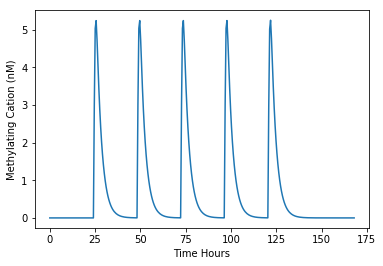

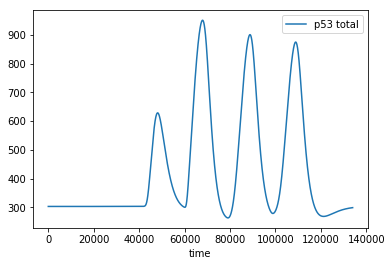

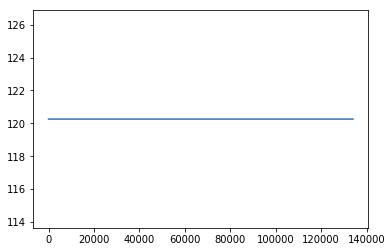

In [38]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from oral_tmz_file import Oral_TMZ
from dna_damage_ode_file import derivative


TMZ_Dose = 10000;   #%in microM  %334.6;
TimeOfDoses = [24,48,72,96,120];    #%Time in hours of doses of TMZ
th = 168;        #%time of simulation(s) in hours

TMZ_input = Oral_TMZ(th, TMZ_Dose, TimeOfDoses);


p53in_total= [];
p53_total  = [];
Mdm2_total = [];
wip1_total = [];
ATMP_total = [];
ATRac_total= [];
BRCA2_total= [];
MSH6_total = [];
MGMT_total = [];
DSB_total = [];
SSB_total = [];
t_total = [];

#Species initial values without intialization

s0 = np.zeros(38)
s0[0] = 2.966386e+02
s0[1] = 6.245528e+00 
s0[2] = 2.056385e+02 
s0[3] = 2.230736e+00 
s0[4] = 0.000000e+00
s0[5] = 0.000000e+00
s0[6] = 6.245528e+00 
s0[7] = 6.245528e+00 
s0[8] = 6.245528e+00 
s0[9] = 6.245528e+00 
s0[10] = 6.245528e+00
s0[11] = 6.245528e+00 
s0[12] = 6.245528e+00 
s0[13] = 6.245528e+00 
s0[14] = 6.245528e+00
s0[15] = 6.245528e+00 
s0[16] = 6.245528e+00 
s0[17] = 6.245528e+00 
s0[18] = 6.245528e+00 
s0[19] = 6.245528e+00 
s0[20] = 6.245528e+00 
s0[21] = 6.245528e+00 
s0[22] = 6.245528e+00 
s0[23] = 6.245528e+00 
s0[24] = 6.245528e+00
s0[25] = 6.245528e+00 
s0[26] = 8.218084e-01 
s0[27] = 4.550432e+01 
s0[28] = 1.202569e+02 
s0[29] = 2.431635e-04 
s0[30] = 6.027760e-06
s0[31] = 0.000000e+00 
s0[32] = 0.000000e+00
s0[33] = 0.000000e+00 
s0[34] = 2.721609e-02 
s0[35] = 0.000000e+00 
s0[36] = 1.503781e+00 
s0[37] = 2.400357e+00

s0_1 = s0*(10**(0))
t = np.linspace(0, 400, 100);


kD_brca_input=1E-5*5;
kD_msh6_input=1E-5;
kD_mgmt_input=1E-5;



tmz_stim = TMZ_input[0];
i = 0;
y = spi.odeint(derivative, s0_1, t, args=(tmz_stim, i, kD_brca_input, kD_msh6_input, kD_mgmt_input, ));



for i in range(0, len(t)):
    p53in_total.append(y[i, 0])
    p53_total.append(y[i, 1])
    Mdm2_total.append(y[i, 2])
    wip1_total.append(y[i, 3])
    ATMP_total.append(y[i, 4])
    ATRac_total.append(y[i, 5])
    BRCA2_total.append(y[i, 26])
    MSH6_total.append(y[i, 27])
    MGMT_total.append(y[i, 28])
    DSB_total.append(y[i, 29])
    SSB_total.append(y[i, 30])
    t_total.append(t[i])


t_max = 400;

for i in range(1, 335):
    
    if i < 335:
        kD_brca_input=1E-5*5;
        kD_msh6_input=1E-5;
        kD_mgmt_input=1E-5;
    else:
        kD_brca_input=1E-2*5;
        kD_msh6_input=1E-2;
        kD_mgmt_input=1E-2;

            
    t = np.linspace(0, t_max, 100);
    y0 = y[-1, :];
    
    if i< 335:
        tmz_stim = TMZ_input[i];
        #print(i);
    else:
        tmz_stim = 0;
    
    y = spi.odeint(derivative, y0, t, args=(tmz_stim, i, kD_brca_input, kD_msh6_input, kD_mgmt_input, ));
        
    for j in range(0, len(t)):
        p53in_total.append(y[j, 0])
        p53_total.append(y[j, 1])
        Mdm2_total.append(y[j, 2])
        wip1_total.append(y[j, 3])
        ATMP_total.append(y[j, 4])
        ATRac_total.append(y[j, 5])
        BRCA2_total.append(y[j, 26])
        MSH6_total.append(y[j, 27])
        MGMT_total.append(y[j, 28])
        DSB_total.append(y[j, 29])
        SSB_total.append(y[j, 30])
        t_total.append((i)*t_max + t[j])
              
p53_combine = [];
for j in range(0, len(p53_total)):
        p53_combine.append(p53_total[j] + p53in_total[j])
        
#stoichometric = genfromtxt('SM_DNA_damage_mgmt.csv', delimiter=',')
   
#plt.plot(t_total, p53in_total, label="p53 inactive")
#plt.plot(t_total, p53_total, label="p53 active")
plt.plot(t_total, p53_combine, label="p53 total")
#plt.plot(t_total, Mdm2_total, label="Mdm2")
#plt.plot(t_total, wip1_total, label="Wip1")
#plt.plot(t_total, ATMP_total, label="ATM-P")
#plt.plot(t_total, ATRac_total, label="ATRac")
#plt.plot(t_total, BRCA2_total, label="BRCA2")
#plt.plot(t_total, MSH6_total, label="MSH6")
#plt.plot(t_total, MGMT_total, label="MGMT")
#plt.plot(t_total, DSB_total, label="DSB")
#plt.plot(t_total, SSB_total, label="SSB")
plt.legend(loc="upper right")
plt.xlabel("time")

#plt.xlim(0, 55);
plt.show()    
plt.plot(t_total, MGMT_total, label="p53 inactive")  
plt.show()    

## Effect of changing Repair genes rate constants. 

The rate equations responsible for the DNA repair by BRCA, MSH6 and MGMt enzymes are

vD[62] = fixdsb1* (BRCA2)(damageDSB)<br>
vD[63] = fixmsh* (MSH6)(damageSSB)<br>
vD[64] = fixmgmt* (MGMT)(damageSSB)<br>

### Normal kD values for repair proteins 
kD_brca_input = 1E-2*5<br>
kD_msh6_input = 1E-2<br>
kD_mgmt_input = 1E-2<br>

### High kD values for repair proteins 
kD_brca_input = 1E-5*5;<br>
kD_msh6_input = 1E-5<br>
kD_mgmt_input = 1E-5<br>


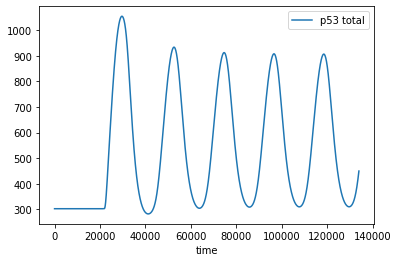

In [40]:
from IPython.display import Image
Image(filename='p53response_norepair.png')





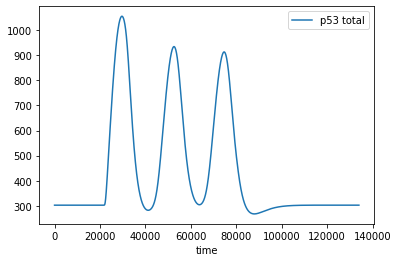

In [44]:
from IPython.display import Image
Image(filename='p53response_halfrepair.png')

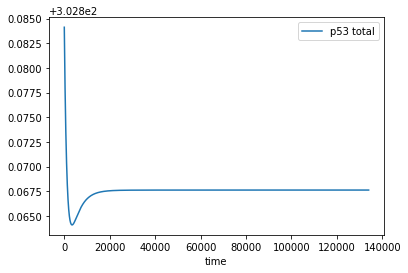

In [51]:
from IPython.display import Image
Image(filename='p53response_repaired.png')

In [55]:
### Initial values for repair proteins 

brca_input = 8.218084e-01 <br>
msh6_input = 4.550432e+01 <br>
mgmt_input = 1.202569e+02 <br>



### Various values for repair proteins 

We changes the initial values of repair proteins by 10, 100, 1000 folds to see the effect of DNA repair mechanism on the tumor cell population


SyntaxError: invalid syntax (<ipython-input-55-9242964743df>, line 3)

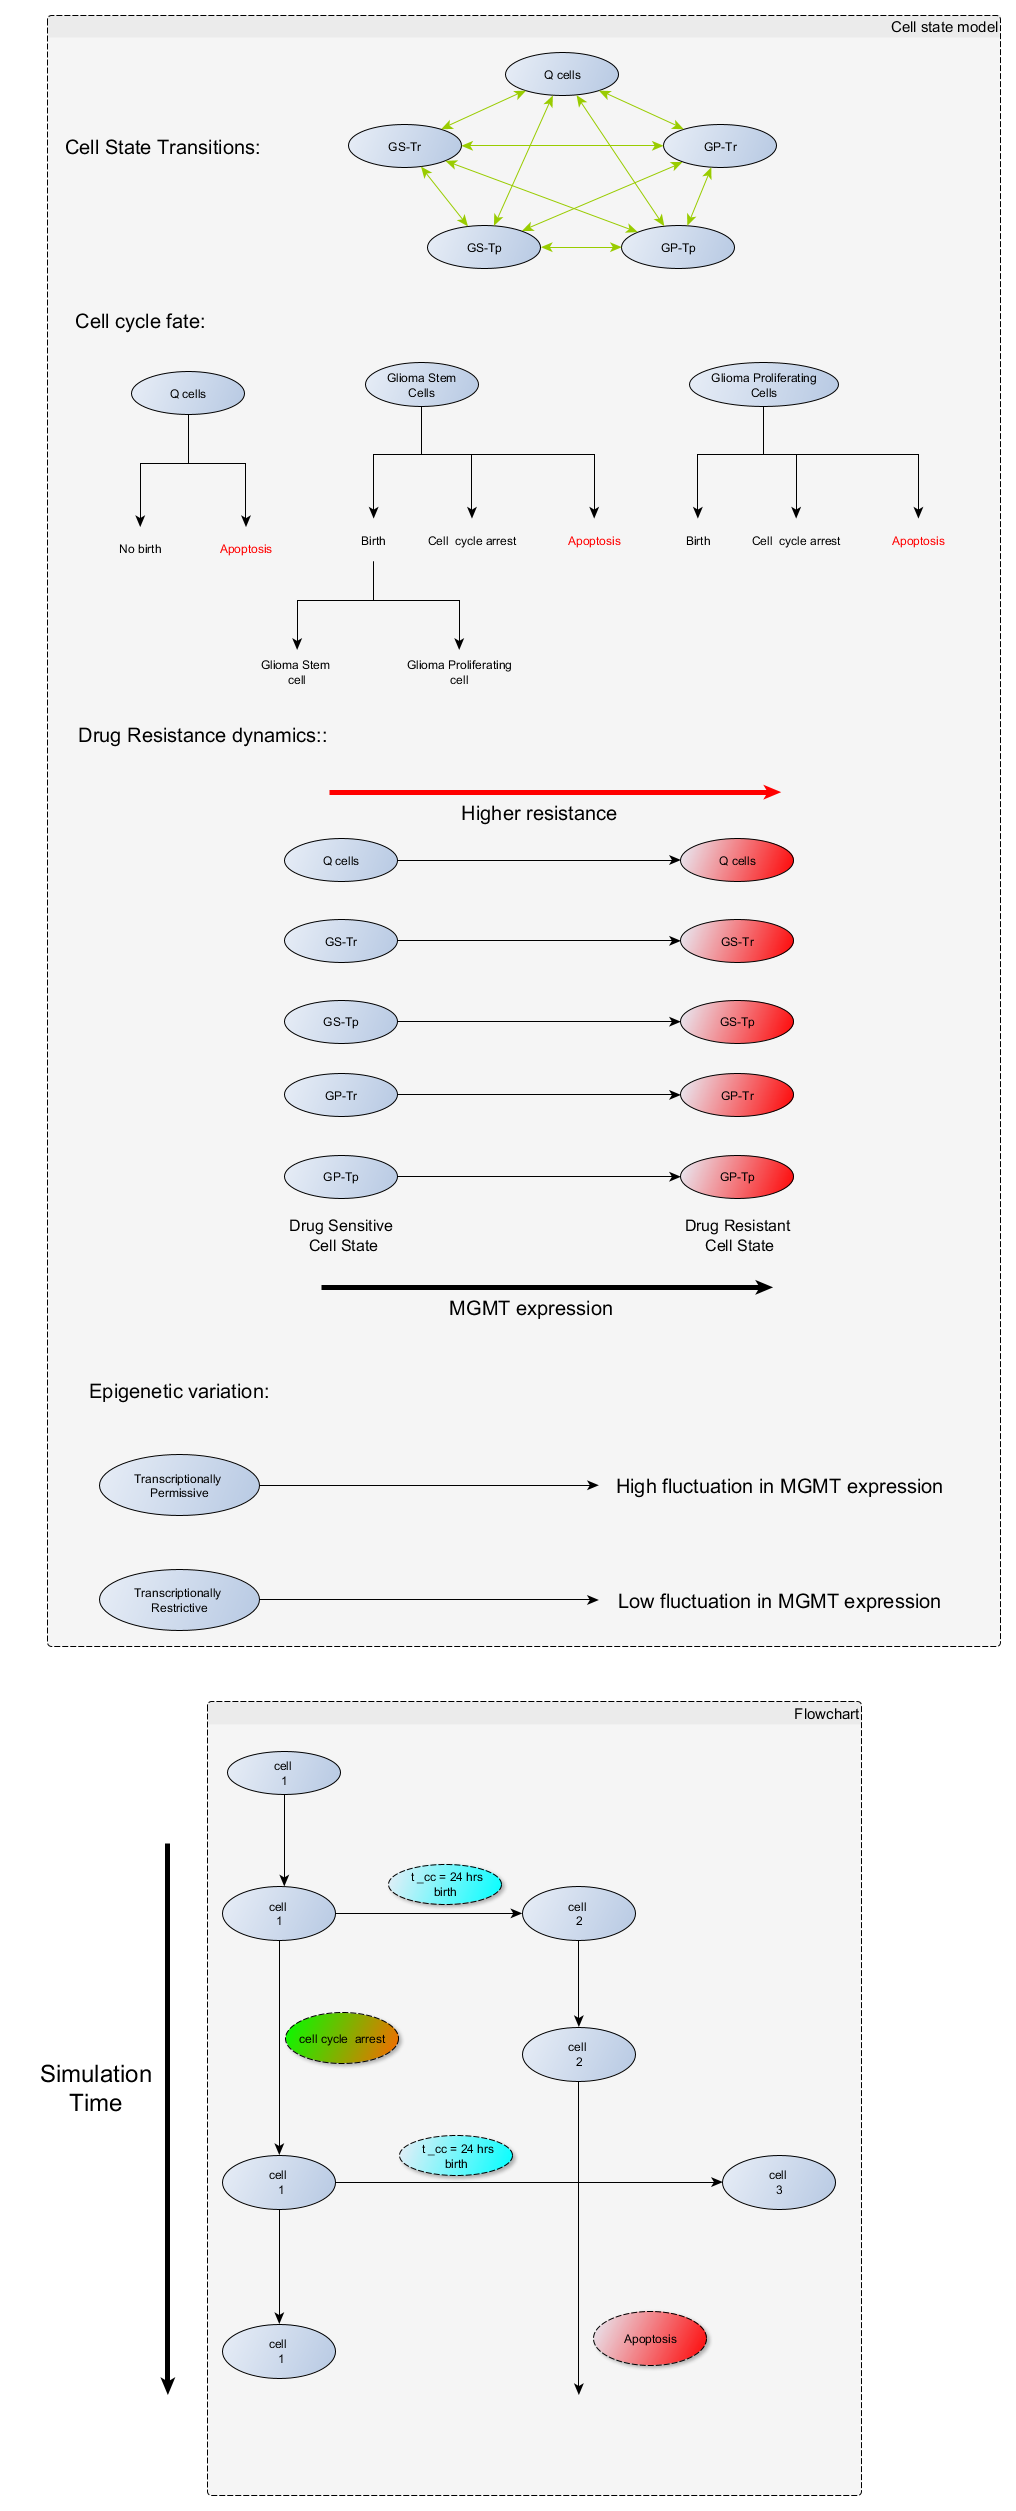

In [67]:
from IPython.display import Image
Image(filename='coding flowchart.png')

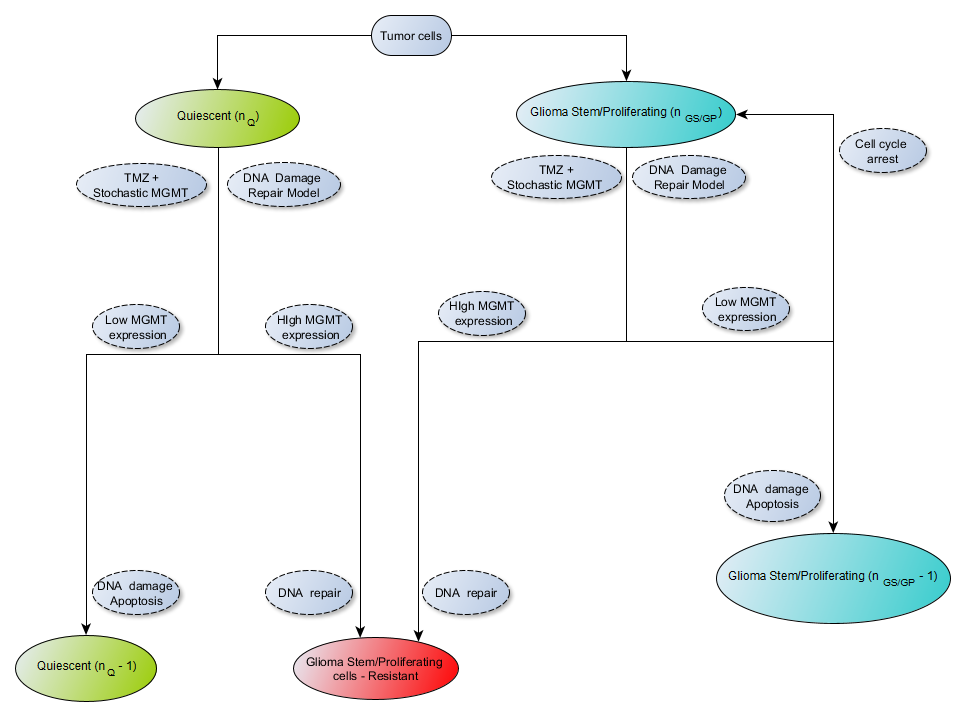

In [66]:
from IPython.display import Image
Image(filename='cell_state_model.png')

In [ ]:
"""
Created on Thu Dec 17 21:07:24 2020

@author: Anshul Saini
"""
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from oral_tmz_file import Oral_TMZ
from dna_damage_ode_file import derivative
from scipy.interpolate import InterpolatedUnivariateSpline


TMZ_Dose = 10000;   #%in microM  %334.6;
TimeOfDoses = [24,48,72,96,120];    #%Time in hours of doses of TMZ
th = 168;        #%time of simulation(s) in hours
div = 1800;
hr = 3600;

TMZ_input = Oral_TMZ(th, div, TMZ_Dose, TimeOfDoses);

simulation_time_hr = np.linspace(0, th, int(th*hr/div));

cell_vector = [1 , 1,  1, 1];
cell_creation_time = [0, 0, 0, 0];
brca2_vector = [1, 10, 100, 1000]
msh6_vector = [1, 10, 100, 1000]
mgmt_vector = [1, 10, 100, 1000]

cell_1_numvector = [1]
cell_1_timevector = [0]
cell_10_numvector = [1]
cell_10_timevector = [0]
cell_100_numvector = [1]
cell_100_timevector =[0]
cell_1000_numvector = [1]
cell_1000_timevector =[0]

brca2 = 1; msh6 = 1; mgmt = 1;

DNA_damage_integral_list = [];

#Species initial values without intialization

s0 = np.zeros(38);

s0[0] = 2.966386e+02; s0[1] = 6.245528e+00; s0[2] = 2.056385e+02; s0[3] = 2.230736e+00; s0[4] = 0.000000e+00; s0[5] = 0.000000e+00; s0[6] = 6.245528e+00; 
s0[7] = 6.245528e+00; s0[8] = 6.245528e+00; s0[9] = 6.245528e+00; s0[10] = 6.245528e+00; s0[11] = 6.245528e+00; s0[12] = 6.245528e+00; s0[13] = 6.245528e+00; 
s0[14] = 6.245528e+00; s0[15] = 6.245528e+00; s0[16] = 6.245528e+00; s0[17] = 6.245528e+00; s0[18] = 6.245528e+00; s0[19] = 6.245528e+00; s0[20] = 6.245528e+00; 
s0[21] = 6.245528e+00; s0[22] = 6.245528e+00; s0[23] = 6.245528e+00; s0[24] = 6.245528e+00; s0[25] = 6.245528e+00; 

s0[26] = 8.218084e-01*brca2; 
s0[27] = 4.550432e+01*msh6; 
s0[28] = 1.202569e+02*mgmt; 

s0[29] = 2.431635e-04; s0[30] = 6.027760e-06; s0[31] = 0.000000e+00; s0[32] = 0.000000e+00; s0[33] = 0.000000e+00; s0[34] = 2.721609e-02; 
s0[35] = 0.000000e+00; s0[36] = 1.503781e+00; s0[37] = 2.400357e+00;

k = 0;
            
while k in range(len(cell_vector)):
    
    brca2 = brca2_vector[k]; 
    msh6 = msh6_vector[k]; 
    mgmt = mgmt_vector[k];
    
    t = np.linspace(0, div, 100);    
    t_cell_cycle = 0;
    initial_time = cell_creation_time[k];
    tmz_stim = TMZ_input[initial_time];
    p53in_total= [];
    p53_total  = [];
    p53_combine = [];
    DSB_total = [];
    SSB_total = [];
    t_total = [];
    
    s0[26] = 8.218084e-01*brca2; 
    s0[27] = 4.550432e+01*msh6; 
    s0[28] = 1.202569e+02*mgmt; 
    
    
    y0 = s0;
    
    for i in range(initial_time, len(simulation_time_hr)):
                
        tmz_stim = TMZ_input[i];
        
        y = spi.odeint(derivative, y0, t, args=(tmz_stim, ));
            
        for j in range(1, len(t)):
            
            DSB_total.append(y[j, 29])
            SSB_total.append(y[j, 30])
            
            t_total.append((i)*div + t[j]);
        
        t_total_hr = [i/(3600) for i in t_total];
        
        DSB_fun = InterpolatedUnivariateSpline(t_total_hr, DSB_total, k = 1);
        SSB_fun = InterpolatedUnivariateSpline(t_total_hr, SSB_total, k = 1);
        DSB_int = DSB_fun.integral(0, t_total[-1]);    
        SSB_int = SSB_fun.integral(0, t_total[-1]);
        DNA_damage_integral = DSB_int + SSB_int;
        apoptosis_limit = 10000;
        
        #print(mgmt, msh6, brca2)
        #print(s0[26],s0[27], s0[28])
        
        if  DNA_damage_integral > apoptosis_limit:   
            
            cell_vector[k] = 0;
            t_cell_cycle = 0;
            
            if brca2 == 1:
                cell_1_numvector.append(-1)
                cell_1_timevector.append(i*div/hr)
            elif brca2 == 10:
                cell_10_numvector.append(-1)  
                cell_10_timevector.append(i*div/hr)
            elif brca2 == 100:
                cell_100_numvector.append(-1)   
                cell_100_timevector.append(i*div/hr)
            elif brca2 == 1000:
                cell_1000_numvector.append(-1)   
                cell_1000_timevector.append(i*div/hr)
            
            print('Apoptosis happened')
            break
        DSB_ave = sum(y[:,29])/len(y[:,29]);
        SSB_ave = sum(y[:,30])/len(y[:,30]);
        
        if  DSB_ave < 2 and SSB_ave < 2:   
            
            t_cell_cycle  = t_cell_cycle + div/hr;
       
        else:
            
            t_cell_cycle  = t_cell_cycle;
            
      #  print(t_cell_cycle,'    ', DSB_ave, '    ', SSB_ave)  
        
        if t_cell_cycle > 24:
            
            cell_vector.append(1);
            cell_creation_time.append(i);
            brca2_vector.append(brca2)
            msh6_vector.append(msh6)
            mgmt_vector.append(mgmt)
            print('cell created', DSB_ave, SSB_ave, brca2)
            if brca2 == 1:
                cell_1_numvector.append(1)
                cell_1_timevector.append(i*div/hr)
            elif brca2 == 10:
                cell_10_numvector.append(1)  
                cell_10_timevector.append(i*div/hr)
            elif brca2 == 100:
                cell_100_numvector.append(1)   
                cell_100_timevector.append(i*div/hr)
            elif brca2 == 1000:
                cell_1000_numvector.append(1)   
                cell_1000_timevector.append(i*div/hr)
            t_cell_cycle = 0
            
        y0 = y[-1, :];   
        
    DNA_damage_integral_list.append(DNA_damage_integral)
    
    print(len(cell_vector));
    print(k);    
    k = k + 1;    


cell_creation_time_hr = [i*div/(3600) for i in cell_creation_time]; 
t_total_hr = [i/(3600) for i in t_total];

cell_number_1 = 0 
cell_number_10 = 0 
cell_number_100 = 0 
cell_number_1000 = 0 
cellnum_1_org = []
celltime_1_org = []
cellnum_10_org = []
celltime_10_org = []
cellnum_100_org = []
celltime_100_org = []
cellnum_1000_org = []
celltime_1000_org = []

for i in np.linspace(0, 170, 1700):
    
    for j in range(len(cell_1_timevector)):
        if i <= cell_1_timevector[j]<= i + 0.1:
            cell_number_1 = cell_number_1 + cell_1_numvector[j]
            cellnum_1_org.append(cell_number_1)    
            celltime_1_org.append(cell_1_timevector[j])  
        else:
            cell_number_1 = cell_number_1
            cellnum_1_org.append(cell_number_1)    
            celltime_1_org.append(i)  
    
    for j in range(len(cell_10_timevector)):
        
        if i <= cell_10_timevector[j] <= i + 0.1:
            cell_number_10 = cell_number_10 + cell_10_numvector[j]
            cellnum_10_org.append(cell_number_10)    
            celltime_10_org.append(cell_10_timevector[j])  
        else:
            cell_number_10 = cell_number_10
            cellnum_10_org.append(cell_number_10)    
            celltime_10_org.append(i)  
    
    for j in range(len(cell_100_timevector)):
        if i <= cell_100_timevector[j]< i + 0.1:
            cell_number_100 = cell_number_100 + cell_100_numvector[j]
            cellnum_100_org.append(cell_number_100)    
            celltime_100_org.append(cell_100_timevector[j])  
        else:
            cell_number_100 = cell_number_100
            cellnum_100_org.append(cell_number_100)    
            celltime_100_org.append(i)   
            
    for j in range(len(cell_1000_timevector)):
        if i <= cell_1000_timevector[j]< i + 0.1:
            cell_number_1000 = cell_number_1000 + cell_1000_numvector[j]
            cellnum_1000_org.append(cell_number_1000)    
            celltime_1000_org.append(cell_1000_timevector[j])  
        else:
            cell_number_1000 = cell_number_1000
            cellnum_1000_org.append(cell_number_1000)    
            celltime_1000_org.append(i)     

       
plt.plot(celltime_1_org, cellnum_1_org, label="MGMT = 1")  
plt.plot(celltime_10_org, cellnum_10_org, label="MGMT = 10")  
plt.plot(celltime_100_org, cellnum_100_org, label="MGMT = 100")  
plt.plot(celltime_1000_org, cellnum_1000_org, label="MGMT = 1000")  
plt.ylabel('Cell number')
plt.xlabel('Time (Hours)')
plt.legend(loc="upper right")
#plt.ylim(0, 350);
plt.xlim(0, 168);
plt.show()    


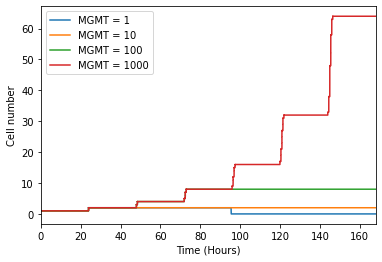

In [49]:
from IPython.display import Image
Image(filename='cell_number_variable_repair_protein.png')

## Cell state population Code 

In [ ]:
"""
Created on Thu Dec 17 21:07:24 2020

@author: Anshul Saini
"""
import numpy as np
import random as rand
import scipy.integrate as spi
import matplotlib.pyplot as plt
from oral_tmz_file import Oral_TMZ
from dna_damage_ode_file import derivative
from scipy.interpolate import InterpolatedUnivariateSpline




TMZ_Dose = 1000;   # in microM  334.6;
TimeOfDoses = [24,48,72,96,120];    # Time in hours of doses of TMZ
th = 200;        # time of simulation(s) in hours
div = 1800;      # Number of seconds after which TMZ output is updated
hr = 3600;

TMZ_input = Oral_TMZ(th, div, TMZ_Dose, TimeOfDoses);  # TMZ output function

simulation_time_hr = np.linspace(0, th, int(th*hr/div)); # Array of simulation time in hours.

# The cell vector containing all the details regarding the cells in the tumor. 

cell_vector =  [[1, 1, 1, 1, 1],          # Cell array each entry represnt a single cell
                [0, 0, 0, 0, 0],          # Time of creation of corresponding cells
                [1, 1, 1, 1, 1],          # BRCA2 concentration for each cell
                [1, 1, 1, 1, 1],          # MSH6 concentration for each cell
                [1, 1, 1, 1, 1],          # MGMT concentration for each cell
                [1, 2, 3, 4, 5]]          # 1 - Q cells  2- GS_Tr 3- GS_Tp 4- GP_Tr 5- GP_Tp

cell_count = [[1], [1], [1], [1], [1]]
time_count = [[0], [0], [0], [0], [0]]

brca2 = 1; msh6 = 1; mgmt = 1;

DNA_damage_integral_list = [];

#Species initial values without intialization

s0 = np.zeros(38);

s0[0] = 2.966386e+02; s0[1] = 6.245528e+00; s0[2] = 2.056385e+02; s0[3] = 2.230736e+00; s0[4] = 0.000000e+00; s0[5] = 0.000000e+00; s0[6] = 6.245528e+00; 
s0[7] = 6.245528e+00; s0[8] = 6.245528e+00; s0[9] = 6.245528e+00; s0[10] = 6.245528e+00; s0[11] = 6.245528e+00; s0[12] = 6.245528e+00; s0[13] = 6.245528e+00; 
s0[14] = 6.245528e+00; s0[15] = 6.245528e+00; s0[16] = 6.245528e+00; s0[17] = 6.245528e+00; s0[18] = 6.245528e+00; s0[19] = 6.245528e+00; s0[20] = 6.245528e+00; 
s0[21] = 6.245528e+00; s0[22] = 6.245528e+00; s0[23] = 6.245528e+00; s0[24] = 6.245528e+00; s0[25] = 6.245528e+00; 

s0[26] = 8.218084e-01;           # Initial BRCA2 concentration
s0[27] = 4.550432e+01;           # Initial MSH6 concentration 
s0[28] = 1.202569e+02;           # Initial MGMTconcentration 

s0[29] = 2.431635e-04; s0[30] = 6.027760e-06; s0[31] = 0.000000e+00; s0[32] = 0.000000e+00; s0[33] = 0.000000e+00; s0[34] = 2.721609e-02; 
s0[35] = 0.000000e+00; s0[36] = 1.503781e+00; s0[37] = 2.400357e+00;

k = 0;

            
while k in range(len(cell_vector[0])):
    
    
    
    brca2 = cell_vector[2][k]; msh6 =  cell_vector[3][k]; mgmt =  cell_vector[4][k]; # repair protein concentration for Kth cell
    
    
    #Stochastic fluctuation in repair protein expressions. For each cell state, the reapir protein value 
    #fluctuates based on Normal(Gaussian) function. For transcriptionally permissive cell state the fluctuations are set
    #to higher values. For transcriptionally recessive cells states fluctuations are set to be lower than Q cells.
    
    if cell_vector[5][k] == 1:   # Qcells 
        brca2 = np.random.normal(brca2, brca2/10, 1); msh6 = np.random.normal(msh6, msh6/10, 1); mgmt =  np.random.normal(mgmt, mgmt/10, 1); 
    elif cell_vector[5][k] == 2: # GS_Tr
        brca2 = np.random.normal(brca2, brca2/20, 1); msh6 = np.random.normal(msh6, msh6/20, 1); mgmt =  np.random.normal(mgmt, mgmt/20, 1);   
    elif cell_vector[5][k] == 3: # GS_Tp
        brca2 = np.random.normal(brca2, brca2/5, 1); msh6 = np.random.normal(msh6, msh6/5, 1); mgmt =  np.random.normal(mgmt, mgmt/5, 1); 
    elif cell_vector[5][k] == 4: # GP_Tr
        brca2 = np.random.normal(brca2, brca2/20, 1); msh6 = np.random.normal(msh6, msh6/20, 1); mgmt =  np.random.normal(mgmt, mgmt/20, 1); 
    elif cell_vector[5][k] == 5: # GP_Tp
        brca2 = np.random.normal(brca2, brca2/5, 1); msh6 = np.random.normal(msh6, msh6/5, 1); mgmt =  np.random.normal(mgmt, mgmt/5, 1); 
    

    t = np.linspace(0, div, 100);    
    t_cell_cycle = 0;
    initial_time = cell_vector[1][k];
    tmz_stim = TMZ_input[initial_time];
    p53in_total= [];
    p53_total  = [];
    p53_combine = [];
    DSB_total = [];
    SSB_total = [];
    t_total = [];
    
    #Updated value of repair proteins after the fluctuations
    
    s0[26] = brca2; 
    s0[27] = msh6; 
    s0[28] = mgmt; 
    
        
    y0 = s0;
    
    for i in range(initial_time, len(simulation_time_hr)):
                
        tmz_stim = TMZ_input[i];         #TMZ input into the DNA damage repair model
        
        y = spi.odeint(derivative, y0, t, args=(tmz_stim, ));
            
        for j in range(1, len(t)):
            
            DSB_total.append(y[j, 29])  # DSB value stored
            SSB_total.append(y[j, 30])  # SSB value stored
            
            t_total.append((i)*div + t[j]);
        
        t_total_hr = [i/(3600) for i in t_total];
        
        DSB_fun = InterpolatedUnivariateSpline(t_total_hr, DSB_total, k = 1);
        SSB_fun = InterpolatedUnivariateSpline(t_total_hr, SSB_total, k = 1);
        DSB_int = DSB_fun.integral(0, t_total[-1]);             # Integrated value of total Double strand breaks 
        SSB_int = SSB_fun.integral(0, t_total[-1]);             # Integrated value of total Single strand breaks 
        DNA_damage_integral = DSB_int + SSB_int;                # Integrated total DNA damage
        apoptosis_limit = 10000;                   # Apoptosis limit. If DNA damage exceed this apoptosis occurs.
        
        #print(mgmt, msh6, brca2)
        #print(s0[26],s0[27], s0[28])
        
        if  DNA_damage_integral > apoptosis_limit:   #Apoptosis loop
            
            cell_vector[0][k] = 0;
            t_cell_cycle = 0;
            
            if cell_vector[5][k] == 1:
                cell_count[0].append(-1)
                time_count[0].append(i*div/hr)
            elif cell_vector[5][k] == 2:
                cell_count[1].append(-1)
                time_count[1].append(i*div/hr) 
            elif cell_vector[5][k] == 3:
                cell_count[2].append(-1)
                time_count[2].append(i*div/hr)    
            elif cell_vector[5][k] == 4:
                cell_count[3].append(-1)
                time_count[3].append(i*div/hr)    
            elif cell_vector[5][k] == 5:
                cell_count[4].append(-1)
                time_count[4].append(i*div/hr)      
            
            print('Apoptosis happened')
            break
        
        brca2_ave = sum(y[:,26])/len(y[:,26]);
        msh6_ave  = sum(y[:,27])/len(y[:,27]);
        mgmt_ave  = sum(y[:,28])/len(y[:,28]);
        DSB_ave   = sum(y[:,29])/len(y[:,29]);
        SSB_ave   = sum(y[:,30])/len(y[:,30]);
        
        if  DSB_ave < 2 and SSB_ave < 2:   # Cell cycle arrest condition
            
            t_cell_cycle  = t_cell_cycle + div/hr;
       
        else:
            
            t_cell_cycle  = t_cell_cycle;       
            
      #  print(t_cell_cycle,'    ', DSB_ave, '    ', SSB_ave)  
        
        if t_cell_cycle > 24:      # Cell reproduction cycle
            
            if cell_vector[5][k] > 1: #Birth process all cells can reproduce except Q cells
            
                cell_vector[0].append(1);
                cell_vector[1].append(i);
                cell_vector[2].append(brca2_ave);
                cell_vector[3].append(msh6_ave);
                cell_vector[4].append(mgmt_ave);
                
            
                print('cell created', DSB_ave, SSB_ave, brca2)
                       

            if cell_vector[5][k] == 2:       #for stem cells there are 50% chance duagter cell is a stem cell or proliferating cell
                            
               u = rand.uniform(0, 1)
               a = np.zeros(2)
               b = [0.5, 0.5]
               a[0] = b[0];
               a[1] = a[0] + b[1];
               tot1 = a[1]
               if 0 < u < a[0]/tot1:                  # Daughter cell is GS-tr
                   cell_vector[5].append(2);          
                   cell_count[1].append(1)
                   time_count[1].append(i*div/hr)
               elif a[0]/tot1 < u < a[1]/tot1:        # Daughter cell si GP-tr
                   cell_vector[5].append(4);       
                   cell_count[3].append(1)
                   time_count[3].append(i*div/hr)
                   print('GStr --> GPtr')
               else:
                   print('error')
        
            elif cell_vector[5][k] == 3:
                
                u = rand.uniform(0, 1)
                a = np.zeros(2)
                b = [0.5, 0.5]
                a[0] = b[0];
                a[1] = a[0] + b[1];
                tot1 = a[1]
                
                if 0 < u < a[0]/tot1:                # Daughter cell is GS-tp
                   cell_vector[5].append(3);
                   cell_count[2].append(1)
                   time_count[2].append(i*div/hr)
                elif a[0]/tot1 < u < a[1]/tot1:      # Daughter cell is GP-tp
                   cell_vector[5].append(5);
                   cell_count[4].append(1)
                   time_count[4].append(i*div/hr)
                   print('GStp --> GPtp')
                else:
                   print('error')
               
                
            
            elif cell_vector[5][k] == 4:
                
                 cell_vector[5].append(4);
                 cell_count[3].append(1)
                 time_count[3].append(i*div/hr)    
                
                
            elif cell_vector[5][k] == 5:
                cell_vector[5].append(5);
                cell_count[4].append(1)
                time_count[4].append(i*div/hr)      
           
            t_cell_cycle = 0
            
            
        arr = [];
        for i in range(5):
            if i != cell_vector[5][k]:
                arr.append(i)
        
        
        ut = rand.uniform(0, 1)
        at = np.zeros(5)
        bt = [0.0001, 0.0001, 0.0001, 0.0001, 0.9996]; # Cell state transitions with 0.01% probability of transition
        at[0] = bt[0];
        at[1] = at[0] + bt[1];
        at[2] = at[1] + bt[2];
        at[3] = at[2] + bt[3];
        at[4] = at[3] + bt[4];
        tot_t = at[4]
        
        if 0 < ut < at[0]/tot_t: 
            cell_vector[5][k] == arr[0];  print('Cell Transistion')
        elif at[0]/tot_t < ut < at[1]/tot_t:
            cell_vector[5][k] == arr[1];  print('Cell Transistion')  
        elif at[1]/tot_t < ut < at[2]/tot_t:
            cell_vector[5][k] == arr[2];  print('Cell Transistion')  
        elif at[2]/tot_t < ut < at[3]/tot_t:
            cell_vector[5][k] == arr[3];  print('Cell Transistion')
        elif at[3]/tot_t < ut < at[4]/tot_t:
            cell_vector[5][k] == cell_vector[5][k];
        else:
            print('error')
            
        y0 = y[-1, :];   
        
    DNA_damage_integral_list.append(DNA_damage_integral) 
    #print(len(cell_vector));
    #print(k);    
    k = k + 1;    

# Re-count of cells for plotting 


cell_count_org = [[], [], [], [], []];
time_count_org = [[], [], [], [], []];
cell_number = [0, 0, 0, 0, 0]

for t in np.linspace(0, simulation_time_hr[-1], 1700):
    
    for i in range(5):
    
        for j in range(len(time_count[i])):
            if t <= time_count[i][j]<= t + 0.1:
                cell_number[i] = cell_number[i] + cell_count[i][j]
                cell_count_org[i].append(cell_number[i])    
                time_count_org[i].append(time_count[i][j])  
            else:
                cell_number[i] = cell_number[i]
                cell_count_org[i].append(cell_number[i]) 
                time_count_org[i].append(t)
       
plt.plot(time_count_org[0], cell_count_org[0], label="Q cells")  
plt.plot(time_count_org[1], cell_count_org[1], label="GStr cells")  
plt.plot(time_count_org[2], cell_count_org[2], label="GStp cells")  
plt.plot(time_count_org[3], cell_count_org[3], label="GPtr cells")  
plt.plot(time_count_org[4], cell_count_org[4], label="GPtp cells")  

plt.ylabel('Cell number')
plt.xlabel('Time (Hours)')
plt.legend(loc="upper right")
#plt.ylim(0, 350);
plt.xlim(0, simulation_time_hr[-1]);
plt.show()    


## Cell Population for different TMZ dose

Below are the plots of the cell population in different cell states for different TMZ concentration 

TMZ = 1 
TMZ = 10
TMZ = 100
TMZ = 1000 (in micromolar)respectively

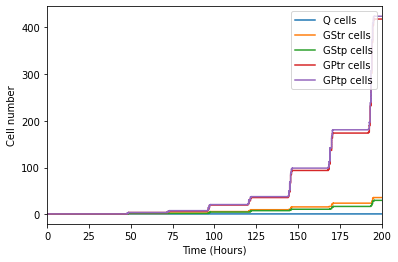

In [62]:
from IPython.display import Image
Image(filename='cell_number_tmz_1.png')


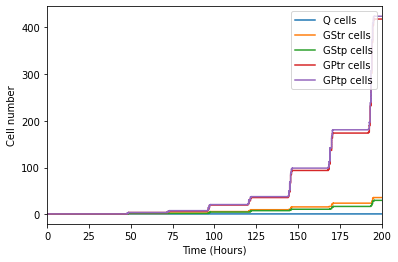

In [63]:
from IPython.display import Image
Image(filename='cell_number_tmz_10.png')

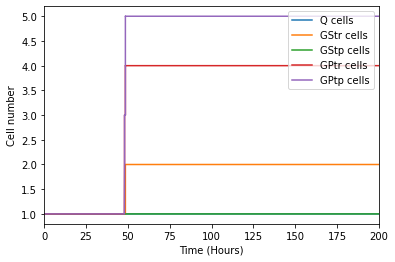

In [64]:
from IPython.display import Image
Image(filename='cell_number_tmz_100.png')

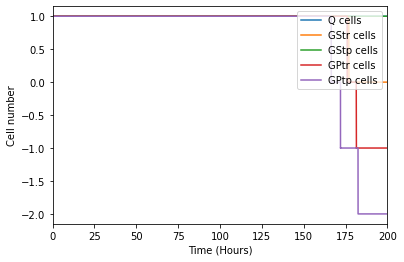

In [65]:
from IPython.display import Image
Image(filename='cell_number_tmz_1000.png')